#### 无损缩小
对于无损缩小有好几种实现方法。这里使用两点 linear scale。首先读取原图像，并对其差分，得到每两点之间的斜率，将离散图像转换为连续的分段函数。然后再根据目标大小对离散图像进行插值。最终返回的是目标图像和原图像的差分。
对目标图像的任何操作都相当于对 $y=kx+b$ 中的 bias 部分进行操作。
#### 无损恢复
已知缩小后的函数是在原连续分段函数上的采样，则可以先根据原图像大小，将缩小后的函数 scale 到原函数大小的区间。
此时对于原图两点之间必须至少知道一点，则可以恢复原图。

#### 具体应用
ORB获取图像特征后，对特征区域进行无损缩放到 8x8 大小，然后进行水印嵌入。
这样得到的特征具有尺度不变性，无论图像的缩放倍数是多少，只要检测到的特征点一致，那么最终缩放得到的8x8大小矩阵就是一样的。
但是当特征区域缩小再放大后将会产生图像质量损失。这种 scale 算法就是用来消除这种质量损失的。
一般需要配合 haar 小波变换，因为如果是一次性 scale 到指定大小然后进行嵌入，该算法将导致较大的图像失真，效果不如 haar

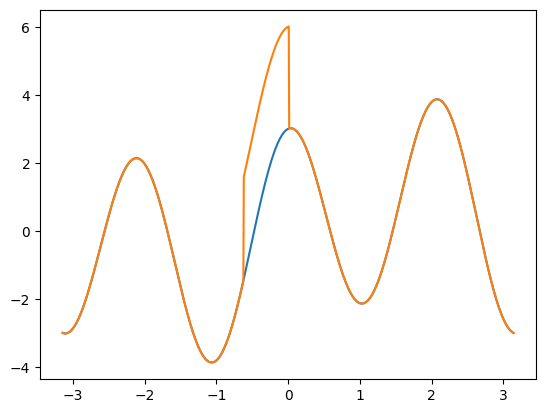

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# 1-D lossless linear scale
def scale(ar: np.ndarray, size: int, axis=-1) -> [np.ndarray, np.ndarray]:
    diff = np.diff(ar, axis=axis)
    p = np.linspace(0, ar.shape[axis], size, endpoint=False)
    left_p = p.astype(int)
    delta_x = p - left_p
    delta_y = diff[left_p] * delta_x
    ret = ar[left_p] + delta_y

    return ret, diff

def inverse_scale(x: np.ndarray, diff: np.ndarray) -> np.ndarray:
    size = diff.size + 1
    assert x.size < size, 'current size must less than original size'
    p = np.linspace(0, size, x.size, endpoint=False)   # restore sample points
    left_p = p.astype(int)
    related_diff = (diff[left_p])
    left, right = x - (p-left_p) * related_diff, x + (1-p+left_p) * related_diff
    ret = np.zeros(size)
    ret[left_p] = left
    ret[left_p+1] = right

    # restore only when scale greater than 2x
    restored_idx = np.unique(np.hstack((left_p, left_p+1)))
    indices_will_restore_count = 1
    remains = None
    while indices_will_restore_count:
        remains = np.setdiff1d(np.arange(size), restored_idx, assume_unique=True)
        indices_will_restore = remains[:-1][np.diff(remains) > 1]
        ret[indices_will_restore] = ret[indices_will_restore+1] - diff[indices_will_restore]

        restored_idx = np.hstack((restored_idx, indices_will_restore))
        indices_will_restore_count = indices_will_restore.size
    for i in remains:
        ret[i] = ret[i-1] + diff[i-1]
    return ret

t = np.linspace(-np.pi, np.pi, 1024)
ar = np.sin(t) + 3*np.cos(3*t)
dst, diff = scale(ar, 10)

dst[5] *= 2

plt.plot(t, ar)
ar_restore = inverse_scale(dst, diff)
# ar_restore = inverse_scale(ar_restore, diff)
plt.plot(t, ar_restore);

从上图可以看见，对于 scale 以后的信号进行操作，相当于对未 scale 的信号进行相同比例的操作。由此对信号的操作具有尺度不变性。
这里的问题在于，当信号进行压缩时，类似的尖峰脉冲信号很容易就会被抹平。
原因是对于信号的拟合被限制在两点之间，当连续的五个点中的第三个点发生变化时，只会影响到旁边的两个点，而其他点不会有任何影响。

如何对 scale 以后的信号进行操作，将尖峰的信号变化隐藏在领域宽度为 l 的区间内？
可以使用加权线性插值。将普通的有两个点参与的差分拓展到有 N 个点参与的加权差分，通过最小二乘法求近似解，对于离中心点越远的差分点取越低的权重。

这种方法是可以写出来的，但有两个前提必须先搞清楚：
1 尖峰脉冲在图像压缩中具体的鲁棒性
2 二维 scale / iscale 函数

对于一维插值在二维上的拓展可以参考[MR-SVD](https://core.ac.uk/download/pdf/11875447.pdf) 中的做法

简单说下 MR-SVD，就是通过坐标奇偶将一维信号转为二维信号，然后通过 PCA 求其近似，将其视为尺度函数。将第二大特征值对应恢复后的向量视为小波函数。


[-0.01177925 -0.09541673  0.02447439  0.20550859  0.32387481  0.37029883
  0.44540811  0.64259039  0.98212604  1.88948929]


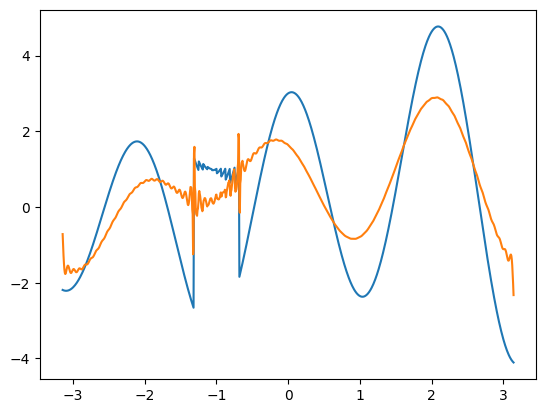

In [28]:
# 使用滤波器进行攻击
from scipy import signal

b, a = signal.butter(2, 0.8, 'lowpass')   #配置滤波器 8 表示滤波器的阶

# embed data
t = np.linspace(-np.pi, np.pi, 1024)
ar = (np.sin(t) + 3*np.cos(3*t)) * np.exp(0.1*t)
dst, diff = scale(ar, 100);
dst[30:40] = 1
ar_restore = inverse_scale(dst, diff)
plt.plot(t, ar_restore)

# attack
ar_restore = signal.filtfilt(b, a, ar_restore)
f = np.fft.fft(ar_restore)
f[3:80] = 0
f[-81:-3] = 0
ar_restore = np.fft.ifft(f).real
plt.plot(t, ar_restore)

# restore data
t_, _ = scale(t, 100)
dst, diff = scale(ar_restore, 100);
print(dst[30:40])

2D loss less scale

Can refer the implementation of 2D [Bicubic inter](https://en.wikipedia.org/wiki/Bicubic_interpolation)


In [57]:
import numpy as np
import cv2 as cv

# 1-D lossless linear scale
def scale(ar: np.ndarray, size: int, axis=-1) -> [np.ndarray, np.ndarray]:
    # swap related axis to top
    if axis != 0:
        ar = np.swapaxes(ar, 0, axis)
    diff = np.diff(ar.astype(float), axis=0)
    p = np.linspace(0, ar.shape[0], size, endpoint=False)
    left_p = p.astype(int)
    delta_x = p - left_p
    delta_y = diff[left_p] * delta_x[:, None, None]
    ret = ar[left_p] + delta_y

    if axis != 0:
        ret, diff = np.swapaxes(ret, 0, axis), np.swapaxes(diff, 0, axis)
    return ret, diff


def inverse_scale(x: np.ndarray, diff: np.ndarray, axis=-1) -> np.ndarray:
    # swap related axis to top
    if axis != 0:
        x = np.swapaxes(x, 0, axis)
        diff = np.swapaxes(diff, 0, axis)
    size = diff.shape[0] + 1
    assert x.shape[0] < size, 'current size must less than original size'
    p = np.linspace(0, size, x.shape[0], endpoint=False)   # restore sample points
    left_p = p.astype(int)
    related_diff = (diff[left_p])
    left, right = x - (p-left_p)[:, None, None] * related_diff, x + (1-p+left_p)[:, None, None] * related_diff
    shape = np.array(diff.shape)
    shape[0] += 1
    ret = np.zeros(shape)
    ret[left_p] = left
    ret[left_p+1] = right

    # restore only when scale greater than 2x
    restored_idx = np.unique(np.hstack((left_p, left_p+1)))
    indices_will_restore_count = 1
    remains = None
    while indices_will_restore_count:
        remains = np.setdiff1d(np.arange(size), restored_idx, assume_unique=True)
        indices_will_restore = remains[:-1][np.diff(remains) > 1]
        ret[indices_will_restore] = ret[indices_will_restore+1] - diff[indices_will_restore]

        restored_idx = np.hstack((restored_idx, indices_will_restore))
        indices_will_restore_count = indices_will_restore.size
    for i in remains:
        ret[i] = ret[i-1] + diff[i-1]

    if axis != 0:
        ret = np.swapaxes(ret, 0, axis)
    return ret


def scale2(ar: np.ndarray, shape) -> [np.ndarray, (np.ndarray, np.ndarray)]:
    shape = np.array(shape)
    ret = ar.copy()
    diff = []
    for axis in np.argwhere(shape != ar.shape):
        axis = axis[0]
        ret, d = scale(ret, shape[axis], axis=axis)
        diff.append(d)
    return ret, diff


def iscale2(ar: np.ndarray, diff) -> np.ndarray:
    for d in diff[::-1]:
        axis = np.argwhere(np.array(ar.shape) != d.shape).flatten()[0]
        ar = inverse_scale(ar, d, axis)
    return ar


src = cv.imread('../data/flower.jpg')
shape = np.array(src.shape)
shape[:2] //= 10
dst, diff = scale2(src, shape)
# plt.imshow(dst)
dst = np.round(dst)
dst[dst > 255]=255
dst[dst < 0]=0
dst = dst.astype(np.uint8)
dst[100:150, 100:150] = 255
cv.imwrite('../data/dst.jpg', dst, [cv.IMWRITE_JPEG_QUALITY, 50])
dst = cv.imread('../data/dst.jpg')
data = iscale2(dst, diff)
print(data.dtype, np.percentile(data, (0,100)), dst.shape)
cv.imwrite('../data/dst.jpg', data)

float64 [-134.07361963  411.57668712] (184, 326, 3)


True